In [103]:
# Data preprocessing, math and plotting
import os
import numpy as np 
import pandas as pd 
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import random
import warnings
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# ML
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, auc, classification_report, r2_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.utils import resample


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trevor.sauerbrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
# HYPERPARAMETERS
RANDOM_STATE = 12
TRAIN_SPLIT = 0.80
OOV_TOK = "<OOV>"
VOCAB_SIZE = 10000
MAX_LENGTH = 120
MAX_ITER = 10000
N_JOBS = 4
N_NEIGHBORS = 5
N_ESTIMATORS = 50
MAX_DEPTH = 1

In [3]:
data = pd.read_csv(r'data/olist_order_reviews_dataset.csv')

In [4]:
# columns_to_keep = ['review_score', 'review_comment_message']
# data_drop = data.drop(columns=[col for col in data.columns if col not in columns_to_keep])
# data_drop

# data_drop_nans = data_drop.dropna(subset=['review_comment_message'])
# nan_counts = data_drop_nans.isnull().sum()
# print(nan_counts)
# data_drop_nans

In [5]:
def clean_data(data, column_text='review_comment_message', 
               column_score='review_score', 
               points_cut = [0, 2, 5], 
               classes = [0, 1]):
    
    df_bin = data
    df_bin = df_bin.dropna(subset=[column_text])
    df_bin['label'] = pd.cut(df_bin[column_score], bins=points_cut, labels=classes)
    df_bin = df_bin.rename(columns={column_text: 'text'})
    df_bin = df_bin[['text','label']]
    
    df_cat = data
    df_cat = df_cat.dropna(subset=[column_text])
    df_cat = df_cat.rename(columns={column_text: 'text' , column_score: 'label'})
    df_cat = df_cat[['text','label']]
    return df_bin ,df_cat

data_bin , data_cat = clean_data(data)

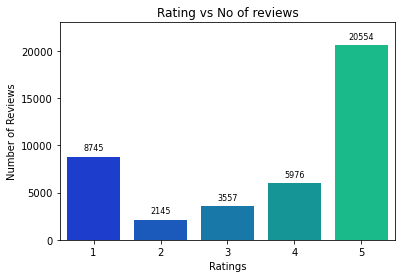

In [6]:
ax = sns.countplot(x=data_cat['label'], palette='winter')
plt.xlabel('Ratings')
plt.ylabel('Number of Reviews')
plt.title('Rating vs No of reviews')

# Add count labels to each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=8)
ax.set_ylim(0, 23000)  # Set the y-axis limit to 0 and 5000

plt.show()

# WORDCLOUD

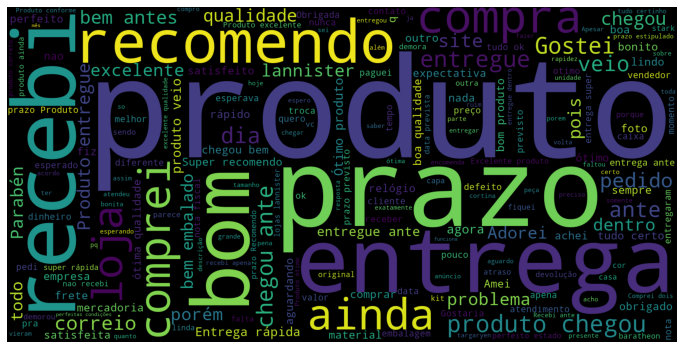

In [12]:
stop_words = stopwords.words('portuguese')
wordcloud = WordCloud(stopwords=stop_words,
                      background_color="black",
                      width=1600, height=800).generate(' '.join(data_bin["text"]))

fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud);

In [105]:
data

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [14]:
# # all data
# def split_test_train(data, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE):
#     df_train = data.sample(frac = split_train, random_state = random_state)
#     df_test = data.drop(df_train.index)

#     X_train = []
#     y_train = []
#     X_test = []
#     y_test = []

#     for index, train in df_train.iterrows():
#         X_train.append(str(train['text']))
#         y_train.append(train['label'])

#     for index, test in df_test.iterrows():
#         X_test.append(str(test['text']))
#         y_test.append(test['label'])

#     y_train = np.array(y_train)
#     y_test = np.array(y_test) 

#     return X_train , y_train , X_test , y_test

# X_train , y_train , X_test , y_test = split_test_train(data_bin, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE)

In [113]:
def split_test_train(data, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE):
    # Separate majority and minority classes
    df_majority = data[data['label']==0]
    df_minority = data[data['label']==1]

    # Undersample majority class
    n_samples = min(len(df_majority), len(df_minority))
    df_majority_downsampled = resample(df_majority, 
                                       replace=False,    # sample without replacement
                                       n_samples=n_samples, # match minority class
                                       random_state=random_state)

    # Combine minority class with downsampled majority class
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    # Split into train and test sets
    df_train = df_balanced.sample(frac=split_train, random_state=random_state)
    df_test = df_balanced.drop(df_train.index)

    X_train = df_train['text'].tolist()
    y_train = df_train['label'].values
    X_test = df_test['text'].tolist()
    y_test = df_test['label'].values

    return X_train , y_train , X_test , y_test

X_train , y_train , X_test , y_test = split_test_train(data_bin, split_train=TRAIN_SPLIT, random_state=RANDOM_STATE)

In [17]:
# Import the Tokenizer class from the keras.preprocessing.text module and instantiate an object with specified parameters.
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token=OOV_TOK)

# Fit the tokenizer on the training set, creating a word index based on the frequency of occurrence of each word in the corpus.
tokenizer.fit_on_texts(X_train)

# Define a function to preprocess the text data by converting each sentence into a sequence of integers using the fitted tokenizer and padding/truncating them to a fixed length.
def preprocess(X_train, X_test, max_length, vocab_size, trunc_type='post', oov_tok = "<OOV>"):

    # Convert each sentence in the training set to a sequence of integers using the fitted tokenizer.
    training_sequences = tokenizer.texts_to_sequences(X_train)

    # Pad the sequences to a fixed length by adding zeros or truncating from the beginning or end based on the trunc_type parameter.
    X_train_padded = pad_sequences(training_sequences,maxlen=max_length, truncating=trunc_type)

    # Convert each sentence in the test set to a sequence of integers using the fitted tokenizer.
    testing_sequences = tokenizer.texts_to_sequences(X_test)

    # Pad the sequences to a fixed length without truncation since the test set should not be modified.
    X_test_padded = pad_sequences(testing_sequences,maxlen=max_length)

    # Return the padded training and test sets as output of the function.
    return X_train_padded, X_test_padded

# Call the preprocess function on the training and test sets to obtain padded and processed data.
X_train, X_test = preprocess(X_train, X_test, MAX_LENGTH, VOCAB_SIZE)

In [20]:
%%time
nb = MultinomialNB()
nb.fit(X_train,y_train)
nb_preds = nb.predict(X_test)
print("Model score on Training Data = ", nb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", nb.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  74.55615886767129 %
Model score on Testing Data =  74.35021354484441 %
Wall time: 79 ms


In [21]:
%%time
lr = LogisticRegression(max_iter= MAX_ITER,random_state=RANDOM_STATE, n_jobs= N_JOBS)
lr.fit(X_train,y_train)
lr_preds = lr.predict(X_test)
print("Model score on Training Data = ", lr.score(X_train,y_train)*100,"%")
print("Model score on Testing Data = ", lr.score(X_test,y_test)*100,"%")

Model score on Training Data =  74.49820023183455 %
Model score on Testing Data =  73.31299572910311 %
Wall time: 3min 41s


In [22]:
%%time
svm = SVC(random_state=RANDOM_STATE , verbose = True)
svm.fit(X_train,y_train)
sv_preds = svm.predict(X_test)
print("Model score on Training Data = ", svm.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", svm.score(X_test,y_test)*100 ,"%")

[LibSVM]Model score on Training Data =  79.7907388200842 %
Model score on Testing Data =  74.49664429530202 %
Wall time: 6min 7s


In [23]:
%%time
rfc = RandomForestClassifier(n_estimators = 100, random_state =RANDOM_STATE , n_jobs = N_JOBS)
rfc.fit(X_train,y_train)
rf_preds = rfc.predict(X_test)
print("Model score on Training Data = ", rfc.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", rfc.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  99.5790372765542 %
Model score on Testing Data =  78.40146430750458 %
Wall time: 3.35 s


In [24]:
%%time
xgb = XGBClassifier(objective='binary:logistic' , 
                    use_label_encoder=False,  
                    random_state = RANDOM_STATE,
                    eval_metric='mlogloss')
xgb.fit(X_train,y_train)
xg_preds = xgb.predict(X_test)
print("Model score on Training Data = ", xgb.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", xgb.score(X_test,y_test)*100 ,"%")

Model score on Training Data =  92.96870233664816 %
Model score on Testing Data =  83.01403294691885 %
Wall time: 8.33 s


In [65]:
%%time
ada_clf = AdaBoostClassifier(random_state=RANDOM_STATE)
ada_clf.fit(X_train, y_train)
ada_preds = ada_clf.predict(X_test)
print("Model score on Training Data = ", ada_clf.score(X_train, y_train)*100 ,"%")
print("Model score on Testing Data = ", ada_clf.score(X_test, y_test)*100 ,"%")

Model score on Training Data =  76.68537612104204 %
Model score on Testing Data =  76.57107992678462 %
Wall time: 8.02 s


In [69]:
%%time
knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
print("Model score on Training Data = ", knn.score(X_train, y_train) * 100, "%")
print("Model score on Testing Data = ", knn.score(X_test, y_test) * 100, "%")

Model score on Training Data =  81.0841315355988 %
Model score on Testing Data =  73.48383160463698 %
Wall time: 42.7 s


In [71]:
%%time
mlp = MLPClassifier(random_state=RANDOM_STATE, verbose=True)
mlp.fit(X_train, y_train)
mlp_preds = mlp.predict(X_test)
print("Model score on Training Data = ", mlp.score(X_train, y_train) * 100, "%")
print("Model score on Testing Data = ", mlp.score(X_test, y_test) * 100, "%")

Iteration 1, loss = 6.28942225
Iteration 2, loss = 4.63893484
Iteration 3, loss = 4.07533070
Iteration 4, loss = 3.70192929
Iteration 5, loss = 3.37079442
Iteration 6, loss = 3.13457185
Iteration 7, loss = 2.94181539
Iteration 8, loss = 2.70897191
Iteration 9, loss = 2.44960553
Iteration 10, loss = 2.40813811
Iteration 11, loss = 2.22020746
Iteration 12, loss = 2.11740944
Iteration 13, loss = 2.11616636
Iteration 14, loss = 1.83439109
Iteration 15, loss = 1.83869359
Iteration 16, loss = 1.69616780
Iteration 17, loss = 1.61867734
Iteration 18, loss = 1.50444388
Iteration 19, loss = 1.45344201
Iteration 20, loss = 1.36810405
Iteration 21, loss = 1.31395413
Iteration 22, loss = 1.24084145
Iteration 23, loss = 1.21917707
Iteration 24, loss = 1.19692482
Iteration 25, loss = 1.06976269
Iteration 26, loss = 1.05818051
Iteration 27, loss = 0.98085750
Iteration 28, loss = 0.97997374
Iteration 29, loss = 0.96453634
Iteration 30, loss = 0.89408494
Iteration 31, loss = 0.87813042
Iteration 32, los

In [78]:
%%time
sgd = SGDClassifier(random_state=RANDOM_STATE, verbose=True)
sgd.fit(X_train, y_train)
sgd_preds = sgd.predict(X_test)
print("Model score on Training Data = ", sgd.score(X_train,y_train)*100 ,"%")
print("Model score on Testing Data = ", sgd.score(X_test,y_test)*100 ,"%")

-- Epoch 1
Norm: 8624.00, NNZs: 44, Bias: 2949.373976, T: 32782, Avg. loss: 4380590.436975
Total training time: 0.02 seconds.
-- Epoch 2
Norm: 5228.62, NNZs: 44, Bias: 3499.473424, T: 65564, Avg. loss: 839657.207237
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 3368.63, NNZs: 44, Bias: 3778.598499, T: 98346, Avg. loss: 493022.438748
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 2162.69, NNZs: 44, Bias: 3970.242287, T: 131128, Avg. loss: 350318.501785
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1907.67, NNZs: 44, Bias: 4106.120713, T: 163910, Avg. loss: 277939.860216
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1788.42, NNZs: 44, Bias: 4215.080207, T: 196692, Avg. loss: 223456.194828
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 1577.72, NNZs: 44, Bias: 4296.365712, T: 229474, Avg. loss: 189836.524264
Total training time: 0.09 seconds.
-- Epoch 8
Norm: 1487.59, NNZs: 44, Bias: 4365.231512, T: 262256, Avg. loss: 159464.110714
Total training time: 0.10 sec

# Confusion Matrices

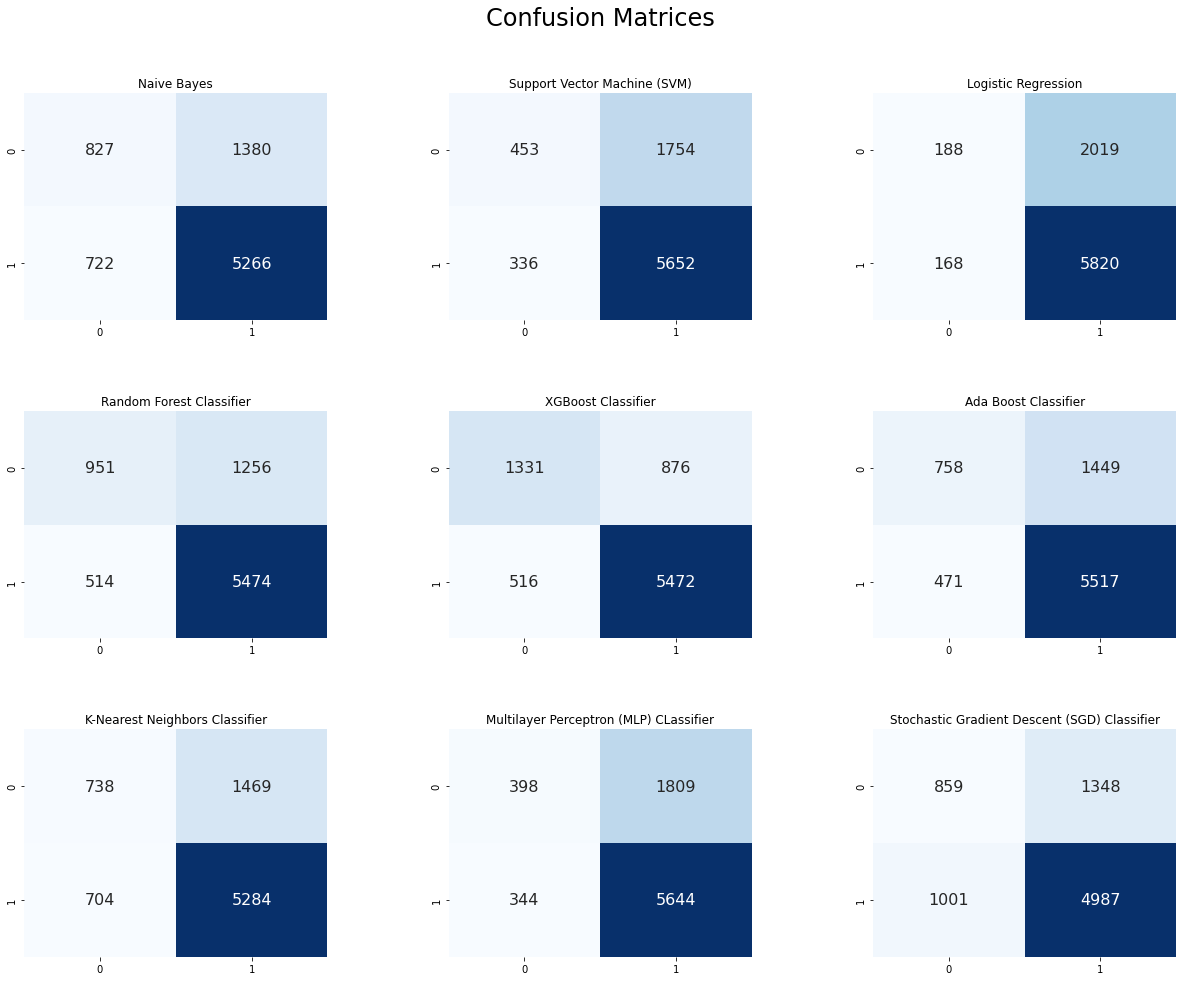

In [84]:
lr_cm=confusion_matrix(y_test, lr_preds )
nb_cm=confusion_matrix(y_test, nb_preds)
svm_cm=confusion_matrix(y_test, sv_preds)
sgd_cm= confusion_matrix(y_test,sgd_preds)
rf_cm = confusion_matrix(y_test,rf_preds)
xg_cm = confusion_matrix(y_test,xg_preds)
ada_cm = confusion_matrix(y_test,ada_preds)
knn_cm = confusion_matrix(y_test,knn_preds)
mlp_cm = confusion_matrix(y_test,mlp_preds)
sgd_cm= confusion_matrix(y_test,sgd_preds)

# plt.figure(figsize=(20,15))
plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(3,3,1)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,3,2)
plt.title("Support Vector Machine (SVM)")
sns.heatmap(svm_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,3,3)
plt.title("Logistic Regression")
sns.heatmap(lr_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,3,4)
plt.title("Random Forest Classifier")
sns.heatmap(rf_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,3,5)
plt.title("XGBoost Classifier")
sns.heatmap(xg_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,3,6)
plt.title("Ada Boost Classifier")
sns.heatmap(ada_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,3,7)
plt.title("K-Nearest Neighbors Classifier")
sns.heatmap(knn_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,3,8)
plt.title("Multilayer Perceptron (MLP) CLassifier")
sns.heatmap(mlp_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplot(3,3,9)
plt.title("Stochastic Gradient Descent (SGD) Classifier")
sns.heatmap(sgd_cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g');

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

# ROC-AUC Curves Comparison

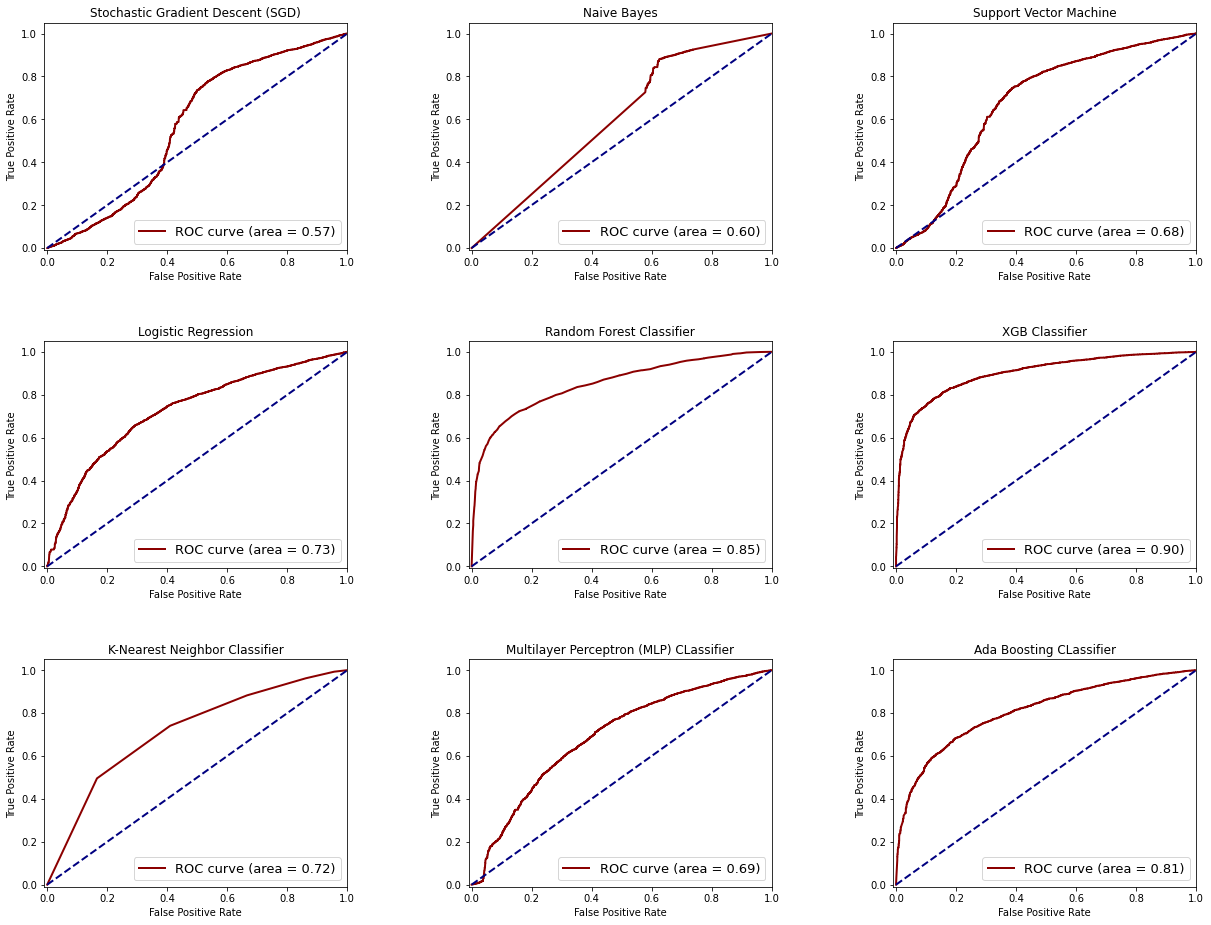

In [93]:
pred_lr = lr.predict_proba(X_test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

pred_nb = nb.predict_proba(X_test)[:,1]
fpr_nb,tpr_nb,_ = roc_curve(y_test,pred_nb)
roc_auc_nb = auc(fpr_nb,tpr_nb)

pred_sgd = sgd.decision_function(X_test)
fpr_sgd,tpr_sgd,_ = roc_curve(y_test,pred_sgd)
roc_auc_sgd = auc(fpr_sgd,tpr_sgd)

pred_svm = svm.decision_function(X_test)
fpr_svm,tpr_svm,_ = roc_curve(y_test,pred_svm)
roc_auc_svm = auc(fpr_svm,tpr_svm)

pred_rf = rfc.predict_proba(X_test)[:,1]
fpr_rf,tpr_rf,_ = roc_curve(y_test,pred_rf)
roc_auc_rf = auc(fpr_rf,tpr_rf)

pred_xg = xgb.predict_proba(X_test)[:,1]
fpr_xg,tpr_xg,_ = roc_curve(y_test,pred_xg)
roc_auc_xg = auc(fpr_xg,tpr_xg)

pred_knn = knn.predict_proba(X_test)[:,1]
fpr_knn,tpr_knn,_ = roc_curve(y_test,pred_knn)
roc_auc_knn = auc(fpr_knn,tpr_knn)

pred_mlp = mlp.predict_proba(X_test)[:,1]
fpr_mlp,tpr_mlp,_ = roc_curve(y_test,pred_mlp)
roc_auc_mlp = auc(fpr_mlp,tpr_mlp)

pred_ada = ada_clf.predict_proba(X_test)[:,1]
fpr_ada,tpr_ada,_ = roc_curve(y_test,pred_ada)
roc_auc_ada = auc(fpr_ada,tpr_ada)

f, axes = plt.subplots(3,3,figsize=(20,15))

axes[0,0].plot(fpr_sgd, tpr_sgd, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_sgd))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Stochastic Gradient Descent (SGD)')
axes[0,0].legend(loc='lower right', fontsize=13);

axes[0,1].plot(fpr_nb, tpr_nb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Naive Bayes')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[0,2].plot(fpr_svm, tpr_svm, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_svm))
axes[0,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Support Vector Machine')
axes[0,2].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Logistic Regression')
axes[1,0].legend(loc='lower right', fontsize=13)

axes[1,1].plot(fpr_rf, tpr_rf, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_rf))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Random Forest Classifier')
axes[1,1].legend(loc='lower right', fontsize=13);

axes[1,2].plot(fpr_xg, tpr_xg, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_xg))
axes[1,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'XGB Classifier')
axes[1,2].legend(loc='lower right', fontsize=13);

axes[2,0].plot(fpr_knn, tpr_knn, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_knn))
axes[2,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[2,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'K-Nearest Neighbor Classifier')
axes[2,0].legend(loc='lower right', fontsize=13);

axes[2,1].plot(fpr_mlp, tpr_mlp, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_mlp))
axes[2,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[2,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Multilayer Perceptron (MLP) CLassifier')
axes[2,1].legend(loc='lower right', fontsize=13);

axes[2,2].plot(fpr_ada, tpr_ada, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_ada))
axes[2,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[2,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Ada Boosting CLassifier')
axes[2,2].legend(loc='lower right', fontsize=13);

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

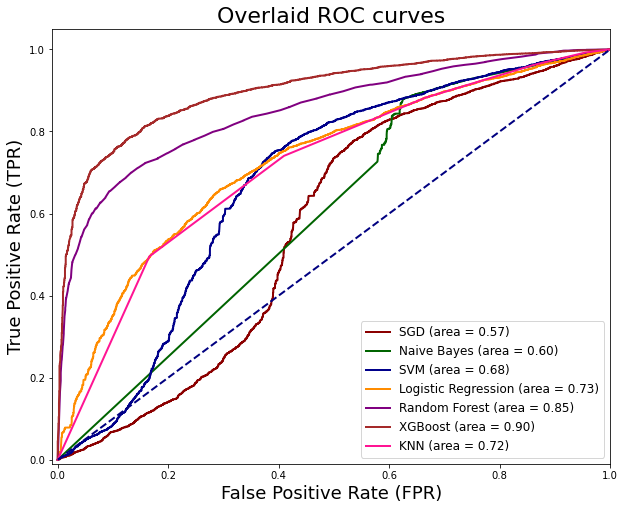

In [118]:
plt.figure(figsize=(10,8))
plt.plot(fpr_sgd, tpr_sgd, color='darkred', lw=2, label='SGD (area = {:0.2f})'.format(roc_auc_sgd))
plt.plot(fpr_nb, tpr_nb, color='darkgreen', lw=2, label='Naive Bayes (area = {:0.2f})'.format(roc_auc_nb))
plt.plot(fpr_svm, tpr_svm, color='darkblue', lw=2, label='SVM (area = {:0.2f})'.format(roc_auc_svm))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='Logistic Regression (area = {:0.2f})'.format(roc_auc_lr))
plt.plot(fpr_rf, tpr_rf, color='purple', lw=2, label='Random Forest (area = {:0.2f})'.format(roc_auc_rf))
plt.plot(fpr_xg, tpr_xg, color='brown', lw=2, label='XGBoost (area = {:0.2f})'.format(roc_auc_xg))
plt.plot(fpr_knn, tpr_knn, color='deeppink', lw=2, label='KNN (area = {:0.2f})'.format(roc_auc_knn))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
plt.title('Overlaid ROC curves', fontsize=22)
plt.legend(loc="lower right", fontsize=12)
plt.show()